<h1 align="center"> Detecting Fraud from transactions</h1>

<h2> Introduction </h2>
In this project we will impolement various predictive models to accurately predict if a transaction is a normal payment or fraud. The input data here is given in JSON format and the features are not scales. We will start by applying various transformations to prepare our data for ingestion by the models. 


<h2> Questions that need to be answered: </h2>

<span style="color:blue"><b>Question 1: Load</b><br></span>
<ul>
<li> <span style="color:blue">a)</span> Programmatically download and load transactions data </li>
<li> <span style="color:blue">b)</span> Describe the structure of the data. Number of records and fields in each record. </li>
<li> <span style="color:blue">c)</span> Determine the Classifiers we are going to use and decide which one has a higher accuracy. </li>
<li> <span style="color:blue">d)</span> Report additional basic summary statistics for each field. Provide count of null, minimum, maximum, and unique values where appropriate. </li>
</ul>

<span style="color:blue"><b>Question 2: Plot</b><br></span>
<ul>
<li> <span style="color:blue">a)</span> Plot histogram of the processed amounts of each transaction (the transactionAmount column) </li>
<li> <span style="color:blue">b)</span> Comment on the underlying structure and your hypotheses about that structure. </li>
</ul>


<span style="color:blue"><b>Question 3: Data Wrangling - Duplicate Transactions</b><br></span>
<ul>
<li> <span style="color:blue">a)</span> Programmatically identify reversed and multiswipe transactions </li>
<li> <span style="color:blue">b)</span> Total number of transactions for reversed transactions and multi-swipe transactions (exclude the first normal transation)</li>
<li> <span style="color:blue">c)</span> Total amound in dollar for reversed transactions and multi-swipe transactions (exclude the first normal transation)</li>
<li> <span style="color:blue">d)</span> Report findnig regarding either transaction</li>
</ul>


<span style="color:blue"><b>Question 4: Model</b><br></span>
<ul>
    
<li> <span style="color:blue">a)</span> Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).</li>
<li> <span style="color:blue">b)</span> Provide an estimate of performance using an appropriate sample, and show your work.</li>
<li> <span style="color:blue">c)</span> Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time</li>
</ul>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import json
from collections import defaultdict
import fraud_detector as frdt
import matplotlib.pyplot as plt
import requests

from datetime import datetime
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, confusion_matrix,
                             plot_precision_recall_curve, roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

fraud_detector is imported


<hr style="border:2px solid red">

<h2><span style="color:blue"><b>Question 1: Load</b><br></span></h2>

<h4><ul>
<li> <span style="color:blue">1.a)</span> I have defined a class that automatically checks the data folder for the existence of the "transactions.txt" file. If the file exists it loads it autmatically as an attribute of the FraudDetection class. The programmatic download and loading is triggered when we define an instance of the class as following:</li>
</ul></h4>

In [2]:
fd = frdt.FraudDetection()

Parsing data...
This will take approximately 80 seconds if the file is already downloaded
Dropping columns: customerId, and single-valued columns


<h4><ui>
<li> <span style="color:blue">1.b)</span> The dataset is consisted of 786363 records/rows and each record has  and 29 columns or fields. Our target field is the "isFraud" column. This column identifies if a transaction was normal, with the value "False", or fraud, with value "True". The details of the fields in every record is as follows:</li>
</ui></h4>

In [4]:
transactions = fd.raw_transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

<h4><ui>
<li> <span style="color:blue">1.c)</span> we can find the null values using the isnull method. Using the isnull method we see that there are no null values in the data. However, there are empty values which we can find as shown below. Additional basic statistics for each field can be found with the describe method from pandas. I have also included the number of unique values for each column below. There are a few columns that are completely empty. These columns can also be filtered out using the single_valued attribute of FraudDetection class in fraud_detector.py. Note that here I have not performed any transformation of the data. I will perform all the necessary transformations in the modeling section.</li>
</ui></h4>

In [5]:
transactions.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [6]:
transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
creditLimit,786363.0,10759.464459,11636.174890,250.00,5000.00,7500.00,15000.000,50000.00
availableMoney,786363.0,6250.725369,8880.783989,-1005.63,1077.42,3184.86,7500.000,50000.00
transactionAmount,786363.0,136.985791,147.725569,0.00,33.65,87.90,191.480,2011.54
currentBalance,786363.0,4508.739089,6457.442068,0.00,689.91,2451.76,5291.095,47498.81


In [7]:
transactions.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521916
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5246
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud             

<h4><ui>
<li> <span style="color:blue">1.c) continued:</span> Let's find and drop the columns that are completely empty using the single_valued attribute of FraudDetection class and look at the cells that are empty.
</li>
</ui></h4>

In [8]:
single_val_cols = transactions.nunique()[transactions.nunique()==1]
transactions = transactions.drop(columns=single_val_cols.index)

In [9]:
empty_vals = np.where(transactions.applymap(lambda x: x == ''))
print(f"number of rows with empty values {np.unique(empty_vals[0]).shape},\n\
number of columns with empty values {np.unique(empty_vals[1]).shape},\n shape of the whole dataset after dropping single valued\
columns: {transactions.shape}")
print (f"percentage of empty rows: {len(empty_vals[0])/ transactions.shape[0]}")
print( f"unique values of 0th element: {np.unique(empty_vals[0])}")
print( f"unique values of 1st element: {np.unique(empty_vals[1])}")

number of rows with empty values (9695,),
number of columns with empty values (5,),
 shape of the whole dataset after dropping single valuedcolumns: (786363, 23)
percentage of empty rows: 0.013285213063178201
unique values of 0th element: [     8    127    139 ... 786127 786140 786147]
unique values of 1st element: [ 7  8  9 10 18]


In [10]:
print ('Columns names that have the empty values are: ')
print (single_val_cols.index)

Columns names that have the empty values are: 
Index(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip',
       'posOnPremises', 'recurringAuthInd'],
      dtype='object')


<h2><span style="color:blue"><b>Question 2: Plot</b><br></span></h2>

<h2>Note that all the functions here are implemented in the fraud_detecto.py script. I will include some of them here and show how the plots or results could be reproduced using the class methods.</h2>

<h4><ui>
<li> <span style="color:blue">2.a) :</span> The following shows the histogram of all the transaction amounts.
</li>
</ui></h4>

In [14]:
# The following plot could also be reproduced with the plot_transaction_amount: fd.plot_transaction_amount()

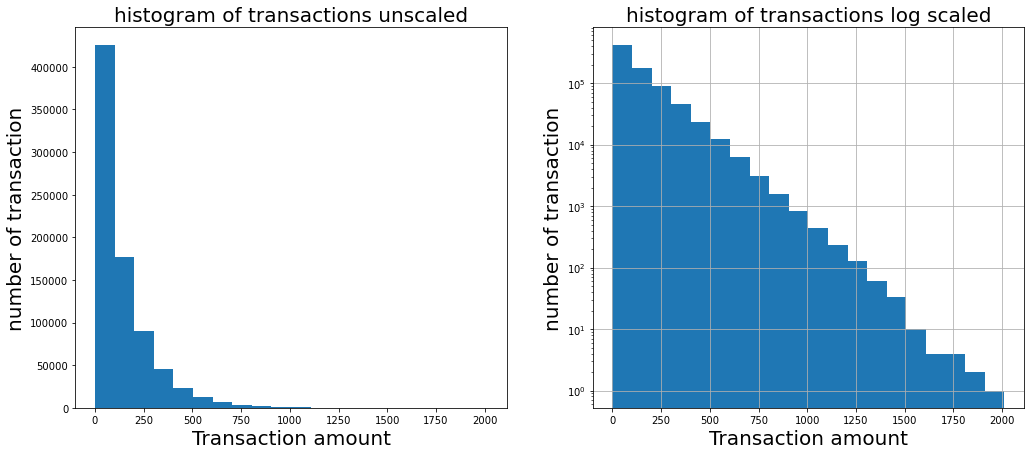

In [13]:
fig, ax = plt.subplots(1,2,figsize=(17,7))
nbins = 20
hist_arr = ax[0].hist(transactions["transactionAmount"], bins=nbins)#.hist(ax = ax[0], bins=20)
transactions["transactionAmount"].hist(ax = ax[1], bins=nbins)
ax[0].set_title('histogram of transactions unscaled', size=20)
ax[0].set_xlabel('Transaction amount', size=20)
ax[0].set_ylabel('number of transaction', size=20)
ax[1].set_title('histogram of transactions log scaled', size=20)
ax[1].set_xlabel('Transaction amount', size=20)
ax[1].set_ylabel('number of transaction', size=20)
ax[1].set_yscale('log')



# ax[0].xticks(fontsize=20)
# ax[0].yticks(fontsize=20)
plt.show()

In [15]:
counts = hist_arr[0]
amounts = hist_arr[1][1:]
print (len(amounts))
percentage = 100*counts/len(transactions)
threshold_percentage = percentage[amounts>1000].sum()
print (f"transaction amounts {hist_arr[1]}")
print (100*counts/len(transactions))
print (100*counts/len(transactions))
print (threshold_percentage)

20
transaction amounts [   0.     100.577  201.154  301.731  402.308  502.885  603.462  704.039
  804.616  905.193 1005.77  1106.347 1206.924 1307.501 1408.078 1508.655
 1609.232 1709.809 1810.386 1910.963 2011.54 ]
[5.40640900e+01 2.25100876e+01 1.14323792e+01 5.84132265e+00
 2.98310068e+00 1.54483362e+00 8.03827240e-01 3.96636159e-01
 2.01560857e-01 1.05422051e-01 5.62081380e-02 2.97572495e-02
 1.62774698e-02 7.63006398e-03 4.19653519e-03 1.27167733e-03
 5.08670932e-04 5.08670932e-04 2.54335466e-04 1.27167733e-04]
[5.40640900e+01 2.25100876e+01 1.14323792e+01 5.84132265e+00
 2.98310068e+00 1.54483362e+00 8.03827240e-01 3.96636159e-01
 2.01560857e-01 1.05422051e-01 5.62081380e-02 2.97572495e-02
 1.62774698e-02 7.63006398e-03 4.19653519e-03 1.27167733e-03
 5.08670932e-04 5.08670932e-04 2.54335466e-04 1.27167733e-04]
0.222162029495284


<h4><ui>
<li> <span style="color:blue">2.b) :</span> The histograms show that the number of transactions exponentially decreases for larger transaction amounts. Approximately more than 50% of the transactions are under a 100 (in the specific currency). and around 23% are between 100-200.  Transactions amoutns higher than 1000 constitute only 0.22 percent of the data. My hypotehsis is that the fradulant transactions happen mostly in the 0-100 range, from a purely statistical point of view. Also if the fradulant transactions are happening in larger amounts, their detection would be much easier. Therefore its likely that we would  would expect them within the smaller transaction amount range. 
</li>
</ui></h4>

<h2><span style="color:blue"><b>Question 3: Data Wrangling - Duplicate Transactions</b><br></span></h2>

<h3>All of the following could be done using the following class method:</h3>

```python:
fd.find_multiswipe_transactions(transactions, dt_threshold = 120, return_table=None, verbose=False)
```


In [16]:
transactions["transactionType"].unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', ''], dtype=object)

<h4><ui>
<li> <span style="color:blue">3.a)</span> Let's first Programmatically identify multiswipe transactions. We note that reversals are 
    already flagged. If I have more time I can look into unmarked category.</li>
</ui>
Lets find multi swipe transactions. These transactions happen only a few seconds apart by definition. So they must happen on the same day but separete time. Probably only a few seconds apart. To this end we need to separate date and time in the transaction datetime column of data.</h4>

In [21]:
#creating date and time columns and dropping transactionDateTime
transactions['date'] = pd.to_datetime(transactions['transactionDateTime']).dt.date
transactions['time'] = pd.to_datetime(transactions['transactionDateTime']).dt.time
transactions = transactions.drop(columns=['transactionDateTime'])

In [22]:
#change col orders for readability
new_col_order = ['accountNumber', 'customerId', 'creditLimit', 'transactionType', 'date', 'time', 'availableMoney',
                 'transactionAmount', 'currentBalance' , 
                 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 
                 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
                 'cardPresent', 'expirationDateKeyInMatch', 'isFraud']
transactions = transactions[new_col_order]

In [23]:
def find_multiswipe_transactions(transactions, verbose=False, dt_threshold = 120, return_table='all'):
    
    """
    This function finds multi-swipe transactions based on the difference between 
    trasaction times. This difference can be changed in dt_threshold.
    Looks at the repeated transactions.
    Assumptions for repeated transactions:
    1- Happend on the same day
    2- Happened consecutively
    3- Transaction amount is the same
    4- Only a few seconds or minutes apart
    5- transactionType might not be specified
    6- availableMoney might be different
    7- currentBalance might be differen
    8- transaction amount is non-zero (the zeros are for verification purposes)
    """
    #first remove columns that are not the same accross multiswipe or duplicate 
    #transactions. 

    cols_to_consider = ['accountNumber', 'date', 'transactionAmount', 'merchantName']
    
    #----------------------------------------older code----------------------------------------#
    # cols_to_consider = []    
    # for column_name in transactions.columns:
    #     #condition excludes the columns that are potentially different between duplicates
    #     condition = column_name not in ['time', 'transactionType', 'availableMoney', 'currentBalance']
    #     if condition:
    #         print (f'\nentered if condition for: {column_name}')
    #         cols_to_consider.append(column_name)
    # if verbose:
    #     print (cols_to_consider)
    #------------------------------------------------------------------------------------------
    
    transactions_no_time = transactions[cols_to_consider]
    duplic_idx = np.where((transactions_no_time.duplicated(keep=False).values==True) & (transactions_no_time['transactionAmount'].values!=0.0))[0]
    duplicated_transactions = transactions.loc[duplic_idx]
    #exclude reversals
    duplicated_transactions = duplicated_transactions[duplicated_transactions['transactionType']=='PURCHASE']
    
    #create a datetime column from date and time columns
    datetime_col = pd.to_datetime(duplicated_transactions['date'].astype(str)+' '+duplicated_transactions['time'].astype(str))
    #convert all the values to seconds in this column. This will be used for tracking time elapsed since last transaction
    min_datetime = datetime_col.min()
    datetime_col = datetime_col.apply(lambda x: (x-min_datetime).total_seconds() )
    #assing this as a column of duplic_trans and call it time_seconds
    duplicated_transactions['tranRelativeSeconds'] = datetime_col    
    j=0
    for i in duplicated_transactions['accountNumber'].unique():
        temp_df = duplicated_transactions[duplicated_transactions['accountNumber']==i]
        temp_df = temp_df.sort_values(by=['tranRelativeSeconds'])
        temp_df["dtTransaction"] = temp_df['tranRelativeSeconds'].diff(1)
        if j==0:
            duplic_trans_with_dt = temp_df
        else:
            duplic_trans_with_dt = pd.concat([duplic_trans_with_dt, temp_df])
        j+=1
        # print(temp_df)    
    
    multiswipe_trans = duplic_trans_with_dt[duplic_trans_with_dt['dtTransaction']<=dt_threshold]
    if 'all' in return_table.lower():
        return multiswipe_trans, duplicated_transactions, duplic_trans_with_dt
    else:
        return multiswipe_trans

In [24]:
multiswipe_trans, duplicated_transactions, duplic_trans_with_dt= find_multiswipe_transactions(transactions)
reversal_trans = transactions[transactions['transactionType']=='REVERSAL']

<h4><ui>
<li> <span style="color:blue">3.b)</span> Total number of transactions for each multiswipe and reversed are as follows</li>
</ui></h4>

In [25]:
print(f"total number of multiswipe trasactions: {multiswipe_trans.shape[0]}")
print(f"total number of reversal trasactions: {reversal_trans.shape[0]}")

print(f"percentage of multiswipe trasactions: {100*multiswipe_trans.shape[0]/transactions.shape[0]:.2f}")
print(f"percentage of reversal trasactions: {100*reversal_trans.shape[0]/transactions.shape[0]:.2f}")

total number of multiswipe trasactions: 4933
total number of reversal trasactions: 20303
percentage of multiswipe trasactions: 0.63
percentage of reversal trasactions: 2.58


<h4><ui>
<li> <span style="color:blue">3.c)</span> Total amount in dollar of transactions for each multiswipe and reversed are as follows</li>
</ui></h4>

In [26]:
print (f"Total dollar amount of multiswipe trasnactions: {multiswipe_trans['transactionAmount'].sum():.2f}")
print (f"Total dollar amount of reverse trasnactions: {reversal_trans['transactionAmount'].sum():.2f}")

print (f"Percentage dollar amount of multiswipe trasnactions: {100*multiswipe_trans['transactionAmount'].sum()/transactions['transactionAmount'].sum():.2f}")
print (f"Percentage dollar amount of reverse trasnactions: {100*reversal_trans['transactionAmount'].sum()/transactions['transactionAmount'].sum():.2f}")

Total dollar amount of multiswipe trasnactions: 744009.15
Total dollar amount of reverse trasnactions: 2821792.50
Percentage dollar amount of multiswipe trasnactions: 0.69
Percentage dollar amount of reverse trasnactions: 2.62


<h4><li> <span style="color:blue">3.d)</span> Our interesting finding is that the proportion of fraud transactions in either multiswipe or reversal categories remains approximately the same as the proportion of fraudulant transactions in the full data set (see below code and plot). The reversal data show slighlty more tendency to be fraud compared total data while the multiswipe (with 120 second threshold in between consecutive transactions) category shows lower tendency to be fraud compared to all transactions. That being said, the total number of fraudulant transactions is more than 4 times higher in reversal data as compared to multiswipes. 

In [27]:
reversal_vals = reversal_trans['isFraud'].value_counts().values
multiswipe_vals = multiswipe_trans['isFraud'].value_counts().values
alltrans_vals = transactions['isFraud'].value_counts().values

print(f"Reversal: {reversal_trans['isFraud'].value_counts().index} , values: {reversal_vals}, fraud percentage: {100*reversal_vals[1]/reversal_vals.sum():.2f}")
print(f"Multiswipe: {multiswipe_trans['isFraud'].value_counts().index}, values: {multiswipe_vals}, fraud percentage: {100*multiswipe_vals[1]/multiswipe_vals.sum():.2f}")
print(f"All transactions: {transactions['isFraud'].value_counts().index}, values: {alltrans_vals}, fraud percentage: {100*alltrans_vals[1]/alltrans_vals.sum():.2f}")

Reversal: Index([False, True], dtype='object') , values: [19966   337], fraud percentage: 1.66
Multiswipe: Index([False, True], dtype='object'), values: [4858   75], fraud percentage: 1.52
All transactions: Index([False, True], dtype='object'), values: [773946  12417], fraud percentage: 1.58


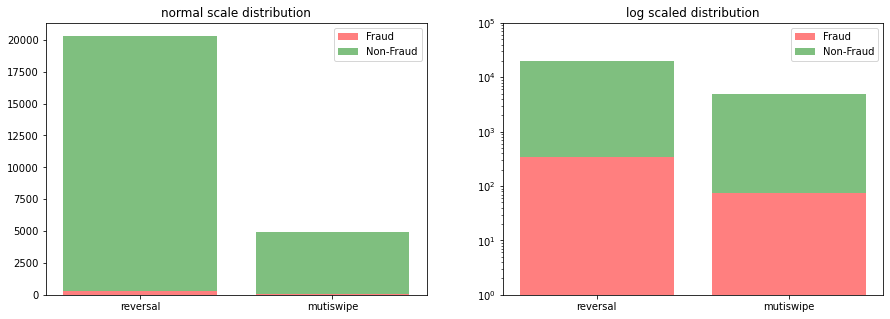

In [28]:
x = ["reversal", "mutiswipe"]
y_True = [reversal_trans['isFraud'].value_counts().values[1], multiswipe_trans['isFraud'].value_counts().values[1]]
y_False = [reversal_trans['isFraud'].value_counts().values[0], multiswipe_trans['isFraud'].value_counts().values[0]]
fix, ax = plt.subplots(1,2, figsize=(15,5))

# plot bars in stack manner
ax[0].set_title('normal scale distribution')
ax[0].bar(x, y_True, color='red', alpha=0.5)
ax[0].bar(x, y_False, bottom=y_True, color='green', alpha=0.5)
ax[0].legend([ "Fraud", "Non-Fraud" ])

ax[1].set_title('log scaled distribution')
ax[1].bar(x, y_True, color='red', alpha=0.5)
ax[1].bar(x, y_False, bottom=y_True, color='green', alpha=0.5)
ax[1].set_yscale('log')
ax[1].set_ylim([10**0, 10**5])
ax[1].legend([ "Fraud", "Non-Fraud" ])
plt.show()

<h2><span style="color:blue"><b>Question 4: Model</b><br></span></h2>

<h4>For our modelling I will try 3 different models. I will first try the models on the unbalanced input data and afterwards do SMOTE oversampling and run all my models on oversampled and balanced data.</h4>

<h4>
<ui> 
<li> <span style="color:blue">Logistic regression: </span> I use logistic regression as my base model. The reason for choosing this model is becuase it deals with linear relations between features, its easy to explain, and its easy and fast to train.</li>

<li> <span style="color:blue">Gradient boosting classifier: </span> This model deals with non-linear relations between features and feature splits. With boosting the predictions are sequential and each iteration learns from the errors of the previous iteration. This improves ther performance metrics. It also has the benefit of explainability. I will choose this model for cross validation and fine tuning. </li>
    
<li> <span style="color:blue">Artificial Neural Networks: </span> I choose ANNs because they are state of the art models. Deeper and bigger networks are typically superior to ther methodologies and have better performance metrics. However, these models require millions of rows of of training data and they are also not easily explainable. I believe with the amount of data we have this model will not perform well.</li>
</ui>
</h4>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import json
from collections import defaultdict
import fraud_detector as frdt
import matplotlib.pyplot as plt
import requests

from datetime import datetime
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, confusion_matrix,
                             plot_precision_recall_curve, roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

fraud_detector is imported


In [2]:
fd = frdt.FraudDetection()

Parsing data...
This will take approximately 80 seconds if the file is already downloaded
Dropping columns: customerId, and single-valued columns


In [3]:
transactions = fd.raw_transactions

In [4]:
rand_state=42

<h2>Feature engineering</h2>

<h3>Note: all the feature engineering can be done with the following method of FraudDetection class. I have included the steps I have taken in more detail here for readability</h3>

```python:
fd.prep_data_all(transactions)
```

<h4>Let's look at single valued columns and one to one columns (one to one means they have the same number of unique values and the 
values in each column have a corresponding value in the other columns)</h4>

In [5]:
uniques = transactions.nunique()
print (uniques)

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521916
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5246
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud             

In [6]:
print ("Is acqCountry and merchantCountryCode one to one: ",transactions['acqCountry'].equals(transactions['merchantCountryCode']))
print ("Is customerId and accountNumber one to one: ",transactions["customerId"].equals(transactions["accountNumber"]))

Is acqCountry and merchantCountryCode one to one:  False
Is customerId and accountNumber one to one:  True


In [7]:
transactions = fd.bool_to_int(transactions)
transactions = fd.drop_extra_cols(transactions)

Dropping columns: customerId, and single-valued columns


In [8]:
transactions_datetime = fd.dates_to_datetime(transactions, verbose=False)
transactions_seconds = fd.datetime_to_ordinal(transactions_datetime)

In [9]:
imputed_transactions, _ = fd.treat_empty_rows(transactions_seconds, impute=False, verbose=False)

In [10]:
# for testing if treat_empty_rows function worked
# print (transactions['acqCountry'].value_counts())
# print (transactions['merchantCountryCode'].value_counts())
# print (transactions['posEntryMode'].value_counts())
# print (transactions['posConditionCode'].value_counts())
# print (transactions['transactionType'].value_counts())

In [11]:
# for testing if treat_empty_rows function worked
# print (imputed_transactions['acqCountry'].value_counts())
# print (imputed_transactions['merchantCountryCode'].value_counts())
# print (imputed_transactions['posEntryMode'].value_counts())
# print (imputed_transactions['posConditionCode'].value_counts())
# print (imputed_transactions['transactionType'].value_counts())

<h3>Convert all objects to numbers and perform labelencoding and one hot encoding</h3>

<ui>
    <li><h4>First convert all the relevant object(strings) to numbers</h4></li>
</ui>

In [12]:
imputed_trasactions_int = fd.stringint_to_int(imputed_transactions)

In [13]:
imputed_trasactions_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776668 entries, 0 to 786362
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             776668 non-null  int64  
 1   creditLimit               776668 non-null  float64
 2   availableMoney            776668 non-null  float64
 3   transactionDateTime       776668 non-null  float64
 4   transactionAmount         776668 non-null  float64
 5   merchantName              776668 non-null  object 
 6   acqCountry                776668 non-null  object 
 7   merchantCountryCode       776668 non-null  object 
 8   posEntryMode              776668 non-null  object 
 9   posConditionCode          776668 non-null  object 
 10  merchantCategoryCode      776668 non-null  object 
 11  currentExpDate            776668 non-null  float64
 12  accountOpenDate           776668 non-null  float64
 13  dateOfLastAddressChange   776668 non-null  f

In [14]:
imputed_trasactions_int[imputed_trasactions_int.select_dtypes(include='object').columns].nunique()

merchantName            2489
acqCountry                 4
merchantCountryCode        4
posEntryMode               5
posConditionCode           3
merchantCategoryCode      19
transactionType            3
dtype: int64

<h3>For the rest of the columns we can use either label encoding or one hot encoding. For columns with smaller unique values I will use one hot encoding and for columns with higher number of unique values I will use label encoding.</h3>

In [15]:
le = preprocessing.LabelEncoder()
cols = ['merchantName', 'merchantCategoryCode']
#df[cols] = #
imputed_trasactions_int[cols] = imputed_trasactions_int[cols].apply(le.fit_transform)

In [16]:
ohenc = preprocessing.OneHotEncoder()
ohenc_cols = ["acqCountry", "merchantCountryCode", "posEntryMode", "posConditionCode", "transactionType"]
# imputed_trasactions_int[cols] = 
for col in ohenc_cols:
    dummies = pd.get_dummies(imputed_trasactions_int[col])
    imputed_trasactions_int = imputed_trasactions_int.drop(columns=[col])
    imputed_trasactions_int = pd.concat([imputed_trasactions_int, dummies], axis=1)

In [17]:
imputed_trasactions_int.shape

(776668, 36)

<h2>Splitting the data</h2>

In [18]:
X = imputed_trasactions_int.drop('isFraud', axis=1)
y = imputed_trasactions_int['isFraud']

In [46]:
def model_results(trained_model, ann=False):
    """Get's the model results that I want for this specific problem"""
    try:
        print(f"Best Parameters: {trained_model.best_params_}")
    except AttributeError:
        pass
    print (X_train.shape, y_train.shape)
    try:
        print(
        f"training score: {trained_model.score(X_train, y_train)}",
        f"testing score: {trained_model.score(X_test, y_test)}"
        )
        y_pred_prob = trained_model.predict_proba(X_test)[:, 1]
    except: 
        print(
        f"training score: {trained_model.evaluate(X_train, y_train)}",
        f"testing score: {trained_model.evaluate(X_test, y_test)}"
        )
        y_pred_prob = model.predict(X_test)
    print ('y_test',y_test)
    print ('y_pred_prob',y_pred_prob)
    print (y_test.shape, y_pred_prob.shape)
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob)}")
    
    # Uses Average Precision as a probability threshold for assignment of classes
    threshold = average_precision_score(y_test, y_pred_prob)
    print(f"{threshold=}")
    y_pred = trained_model.predict(X_test)
    if ann:
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    predictions = np.where(y_pred_prob > threshold, 1, 0)
    print("y_test distribution", np.bincount(y_test))
    print("prediction distribution", np.bincount(predictions == 1))

    # Plot PR Curve
    plot_precision_recall_curve(trained_model, X_test, y_test)
    plt.show()
    
    # Plotting confusion Matrices
    f, axes = plt.subplots(1, 2, sharey=True, figsize=[15, 5])
    axes[0].set_title("Confusion Matrix 50/50")
    try:
        sns.heatmap(confusion_matrix(y_test.to_numpy(), y_pred), annot=True, fmt='g', ax=axes[0])
    except:
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=axes[0])
    axes[1].set_title("Confusion Matrix - Custom Threshold")
    try:
        sns.heatmap(confusion_matrix(y_test.to_numpy(), predictions), annot=True, fmt='g', ax=axes[1])
    except:
        sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g', ax=axes[1])
    plt.show()

<h2>Logistic Regression</h2>

In [20]:
X_train, X_valid, X_test, y_train, y_valid, y_test = fd.train_test_val(imputed_trasactions_int, verbose=True)

X_train: (621334, 35)
X_valid: (77667, 35)
X_test: (77667, 35)
y_train: (621334,)
y_valid: (77667,)
y_test: (77667,)


In [ ]:
pipeline = fd.basic_regression(X_train, y_train)
model_results(pipeline)

<h3>
Basic logistic regression with 0.5 probability fails to identify True positive i.e. fraud cases. In order to tackle this issue we can move the prediction probability threshold. This is done by using the average precession (AP) score. Now, if we compare the probability to the AP score threshold and assign all values with probability higher than threshold as fraud and everything below that as non-fraud cases our model seems to perform better. We can see this in the right heatmap plot above. Let's now apply all our models with balanced data either through undersampling, oversamplint, or SMOTE sampling. I will go with SMOTE sampling since undersampling might not be ideal for when we apply the artificial neural network (ANN) model.
</h3>

<h2>Gradient Boosting Classifier</h2>

In [ ]:
gboost = fd.fine_tuned_gboost(X_train, y_train)

Best Parameters: {'classifier__max_depth': 6, 'classifier__max_features': 4}
(621334, 35) (621334,)
training score: 0.03321842682544657 testing score: 0.016570008285004142
ROC AUC Score: 0.8187771611280521
threshold=0.12812075664445746
y_test distribution [76460  1207]
prediction distribution [77244   423]


/Users/sayebms1/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


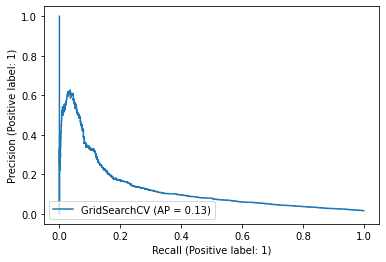

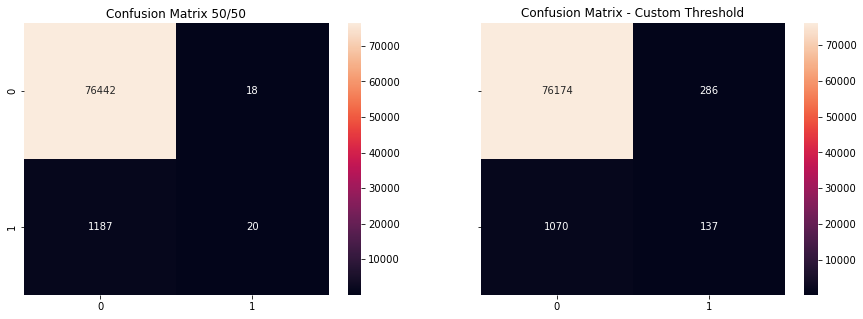

In [44]:
model_results(gboost)

<h2>Artificial Neural Network</h2>

In [21]:
model = fd.simple_ann(X_train, y_train, X_valid, y_valid, metrics='binary_accuracy')

2022-05-13 12:22:03.684643: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
9709/9709 [==============================] - 11s 1ms/step - loss: 0.0785 - binary_accuracy: 0.9845 - val_loss: 0.0742 - val_binary_accuracy: 0.9845
Epoch 2/5
9709/9709 [==============================] - 11s 1ms/step - loss: 0.0744 - binary_accuracy: 0.9846 - val_loss: 0.0745 - val_binary_accuracy: 0.9845
Epoch 3/5
9709/9709 [==============================] - 11s 1ms/step - loss: 0.0740 - binary_accuracy: 0.9846 - val_loss: 0.0745 - val_binary_accuracy: 0.9845
Epoch 4/5
9709/9709 [==============================] - 11s 1ms/step - loss: 0.0738 - binary_accuracy: 0.9846 - val_loss: 0.0741 - val_binary_accuracy: 0.9845
Epoch 5/5
9709/9709 [==============================] - 11s 1ms/step - loss: 0.0736 - binary_accuracy: 0.9846 - val_loss: 0.0735 - val_binary_accuracy: 0.9845


In [60]:
model.evaluate(X_test, y_test)

2428/2428 [==============================] - 2s 686us/step - loss: 0.0750 - binary_accuracy: 0.9843


[0.0750325471162796, 0.9843176603317261]

<h2>Logistic regression with SMOTE oversampling</h2>

<h3>Note: you can do under sampling or over sampling with the sampler_type in fd.data_sampler method</h3>

In [33]:
from collections import Counter
from sklearn.datasets import make_classification

In [36]:
X_res, y_res = fd.data_sampler(X_train, y_train, sampler_type='SMOTE') #pick sampling method 'over sample', under sample, SMOTE

SMOTE sampling
Original dataset shape Counter({0: 611787, 1: 9547})
Resampled dataset shape Counter({0: 611787, 1: 611787})


(621334, 35) (621334,)
training score: 0.6590625975723202 testing score: 0.658220350985618
(77667,) (77667,)
ROC AUC Score: 0.7102659808987354
threshold=0.04160960688835699
y_test distribution [76449  1218]
prediction distribution [    0 77667]


/Users/sayebms1/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


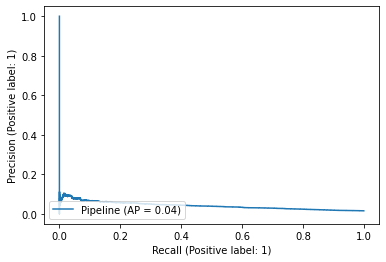

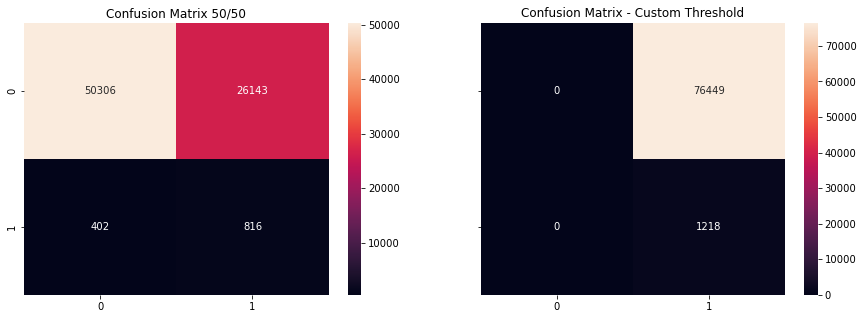

In [37]:
pipeline = fd.basic_regression(X_res, y_res)
model_results(pipeline)

<h2>Gradient Boosting Classifier with SMOTE oversampling</h2>

In [38]:
gboost = fd.fine_tuned_gboost(X_res, y_res)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START classifier__max_depth=3, classifier__max_features=3.........
[CV 1/2; 1/6] END classifier__max_depth=3, classifier__max_features=3;, score=0.798 total time=  47.3s
[CV 2/2; 1/6] START classifier__max_depth=3, classifier__max_features=3.........
[CV 2/2; 1/6] END classifier__max_depth=3, classifier__max_features=3;, score=0.806 total time=  47.2s
[CV 1/2; 2/6] START classifier__max_depth=3, classifier__max_features=4.........
[CV 1/2; 2/6] END classifier__max_depth=3, classifier__max_features=4;, score=0.808 total time=  56.4s
[CV 2/2; 2/6] START classifier__max_depth=3, classifier__max_features=4.........
[CV 2/2; 2/6] END classifier__max_depth=3, classifier__max_features=4;, score=0.820 total time=  57.8s
[CV 1/2; 3/6] START classifier__max_depth=5, classifier__max_features=3.........
[CV 1/2; 3/6] END classifier__max_depth=5, classifier__max_features=3;, score=0.845 total time= 1.3min
[CV 2/2; 3/6] START 

Best Parameters: {'classifier__max_depth': 6, 'classifier__max_features': 4}
(621334, 35) (621334,)
training score: 0.5447784644390908 testing score: 0.48111658456486045
(77667,) (77667,)
ROC AUC Score: 0.7418813514686082
threshold=0.06492443590376132
y_test distribution [76449  1218]
prediction distribution [ 9495 68172]


/Users/sayebms1/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


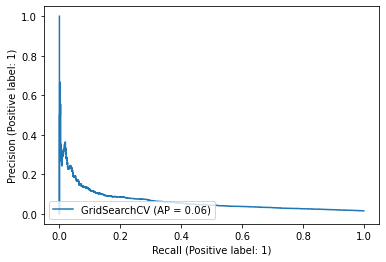

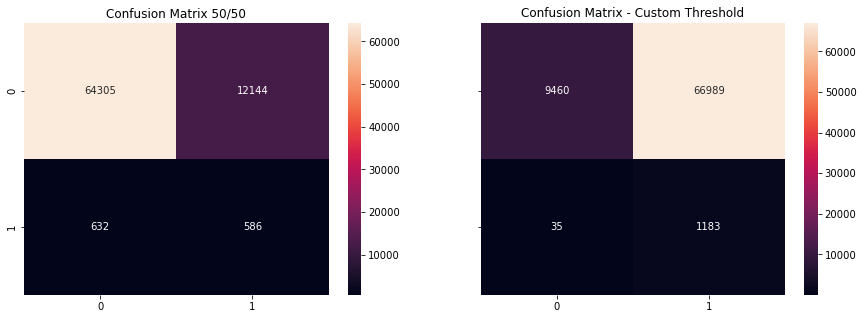

In [39]:
model_results(gboost)

<h3>ANN with SMOTE oversampling</h3>

In [61]:
model = fd.simple_ann(X_res, y_res, X_valid, y_valid, metrics='binary_accuracy')

Epoch 1/5
19119/19119 [==============================] - 20s 990us/step - loss: 0.5621 - binary_accuracy: 0.7103 - val_loss: 0.5935 - val_binary_accuracy: 0.7002
Epoch 2/5
19119/19119 [==============================] - 19s 1ms/step - loss: 0.5298 - binary_accuracy: 0.7351 - val_loss: 0.6037 - val_binary_accuracy: 0.6715
Epoch 3/5
19119/19119 [==============================] - 19s 984us/step - loss: 0.5217 - binary_accuracy: 0.7400 - val_loss: 0.5585 - val_binary_accuracy: 0.7215
Epoch 4/5
19119/19119 [==============================] - 19s 979us/step - loss: 0.5180 - binary_accuracy: 0.7424 - val_loss: 0.6028 - val_binary_accuracy: 0.6770
Epoch 5/5
19119/19119 [==============================] - 21s 1ms/step - loss: 0.5140 - binary_accuracy: 0.7445 - val_loss: 0.5692 - val_binary_accuracy: 0.7212


In [62]:
score = model.evaluate(X_test, y_test)

2428/2428 [==============================] - 2s 762us/step - loss: 0.5726 - binary_accuracy: 0.7173


In [63]:
score

[0.5726101994514465, 0.7173059582710266]

In [89]:
Counter(pd.DataFrame(y_pred))

Counter({0: 1})

<h2>Conclusion</h2>

From the two models that I finalized analyzing (gradient boosting, and basic regression) the gradient boosting seems to perform better at identifying anomalies. Overall the introduction of a probability threshold based on average precesion score seems to help in identification of fraudulant transactions. My implementation of ANN is not complete yet and is part of next steps.

<h2>Next steps</h2>

<ui>
<li>
More feature engineering. For instance I can make signle columns from card cvv and entered cvv by looking at the difference and marking 1 or 0 if the entered cvv and card cvv match or not. I can also add the time elapsed since last transaction into the model. Though that was initially my plan but I didn't have time to impolement it. 
</li>

<li>
I have not yet finalized the implementation of ANN. As a next step I would like to finaslize the model_results function to visualize for the performance of ANN. 
</li>
    
    

<li>
The question regarding the reversal transactions was not very clear. Though they reversals are flagged in the data I did not have much time to look at them. I tried a quick elapsed time threshold estimation by taking any duplicate transaction that happens in 120 seconds multiswipe and all transaction beyond that as reversal. This, however proved to be insufficient, as it does not take into account subscriptions which look typically like a duplicate transaction if the time periodicity is not taken into account. Therefore, if given more time I can look in more detail into the reversals and also unmarked categories. 
</li>
    
<li>
For simpliclity I have done only 2 cv on my gradeitn boosting classifier. As a next step I could explore more of the feature space and perform more cross validations. I can also explore different ANN configurations for my ANN model. 
</li>
    
<li>
For over sampling I can impolement Generative Networks to get synthetic data to train my models. 
</li>
    
<li>
Train an anomally detection algorithm. This works by training an autoencoder with one of the labels. The model will learn to encode and decode that specific class and whenever its fed an anomalous feature set it will not be able to reproduce the targets that it was trained on. This another method worth exploring with fraud detection as fraudulant transactions are a good example of anomalous event.     
</li>
    
    
<li>
From a coding perspective I did not have time to implement unit testing. Therefore, if given more time this is an important next step that I need to do.
</li>
    
</ui>

<h2>References</h2>

Various references has been used in the compilation of this notebook. I have used scikitlearn, keras, and pandas webpages and the example codes therein. I have used references from Kaggle notebooks and github resources. 


- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- https://machinelearningmastery.com/imbalanced-classification-with-the-fraudulent-credit-card-transactions-dataset/